## -- 9/22/2025 --


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [ ]:
# last 30 day BTC prices
btc = yf.download('BTC-USD', period='30d')
print(btc.head())

/tmp/ipython-input-2377849851.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download('BTC-USD', period='30d')
[*********************100%***********************]  1 of 1 completed

Price               Close           High            Low           Open  \
Ticker            BTC-USD        BTC-USD        BTC-USD        BTC-USD   
Date                                                                     
2025-08-24  113458.429688  115615.085938  111060.546875  115387.390625   
2025-08-25  110124.351562  113637.843750  109324.281250  113456.898438   
2025-08-26  111802.656250  112397.015625  108762.039062  110124.101562   
2025-08-27  111222.062500  112619.414062  110398.265625  111795.710938   
2025-08-28  112544.804688  113450.078125  110900.921875  111219.054688   

Price            Volume  
Ticker          BTC-USD  
Date                     
2025-08-24  73961489632  
2025-08-25  85706860190  
2025-08-26  69396320317  
2025-08-27  62137056409  
2025-08-28  58860155962  


Price               Close           High            Low           Open  \
Ticker            BTC-USD        BTC-USD        BTC-USD        BTC-USD   
Date                                                                     
2025-08-30  108808.070312  108929.351562  107444.445312  108409.406250   
2025-08-31  108236.710938  109491.000000  108104.656250  108818.460938   
2025-09-01  109250.593750  109890.585938  107271.179688  108228.750000   
2025-09-02  111200.585938  111748.015625  108454.031250  109243.070312   
2025-09-03  111723.210938  112600.226562  110582.960938  111190.695312   

Price            Volume      7-Day_SMA  
Ticker          BTC-USD                 
Date                                    
2025-08-30  51486264208  110910.172991  
2025-08-31  47986191770  110164.213170  
2025-09-01  66870372995  110039.390625  
2025-09-02  74776999491  109953.380580  
2025-09-03  61119643565  110024.973214  


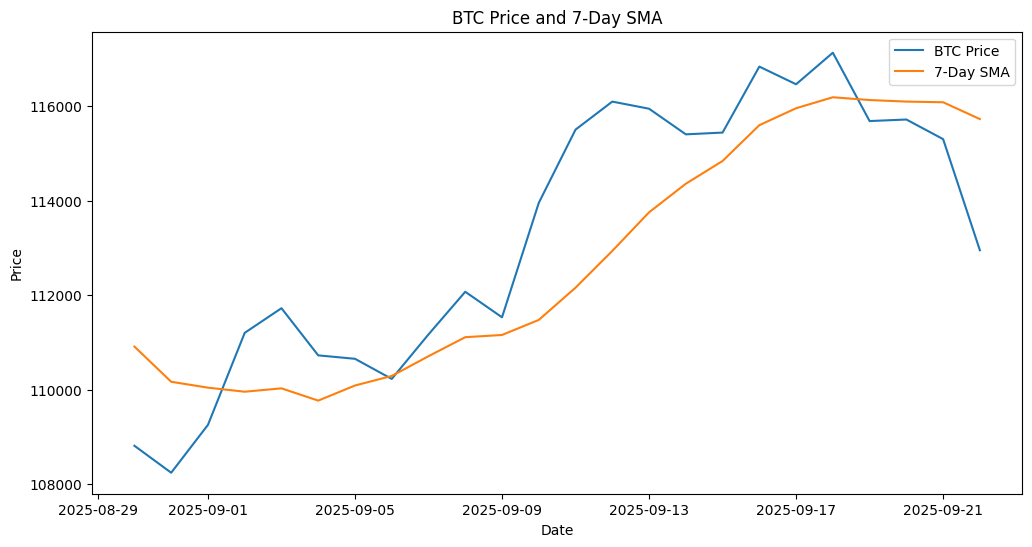

In [ ]:
btc['7-Day_SMA'] = btc['Close'].rolling(window=7).mean()
btc = btc.dropna()
print(btc.head())

plot = plt.figure(figsize=(12, 6))
plt.plot(btc['Close'], label='BTC Price')
plt.plot(btc['7-Day_SMA'], label='7-Day SMA')
plt.title('BTC Price and 7-Day SMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()